# TuRBO for solving ODEs

### Import dependencies

In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib

from TuRBO.benchmark.rom import SiROM
from TuRBO.turbo_rei import turbo

/Users/saiaakashramesh/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup the problem and TuRBO settings

In [2]:
# Smoke test
path_dir = "results"  # path to the output directory
# problems = [
#     "HPA101-0"
# ]  # problem name, see the above list or src/define_problems.py
problem = "SiROM-Temp"
itrials = 1  # run number also used as random seed
ns_init = 30  # number of initial samples for each trust region
ns_max = 500  # number of maximum function evaluation
ns_max_gp = 40  # number of maximum function evaluation for GP-EI
ns_max_saasbo = 31  # number of maximum function evaluation for SAASBO
verbose = True

# for TuRBO-m-REI
acqf = "EI"  # acquisition function in TuRBO: 'EI' or 'TS'
racqf = "qREI"  # region-averaged acquisition function: 'REI', 'qREI', 'EI', 'qEI, 'RUCB', 'UCB', or None (None results in the usual TuRBO)
n_trust_regions = 1  # 1:TuRBO-1, m>1:TuRBO-m
batch_size = 1  # batch size for local seach in TuRBO
n_init_region = ns_init  # number of initial sample points when TuRBO starts with REI

dim = 6
dim_emb = 0
device = "cpu"

if "SiROM" in problem:
    problem = problem.split("-")[1]
    problem = SiROM(problem, dim=6, noise_std=None, negate=False)

### Run TuRBO

In [3]:
# Run TuRBO
turbo(
    path_dir,
    problem,
    int(ns_init),
    int(ns_max),
    int(dim),
    int(dim_emb),
    int(itrials),
    verbose,
    int(n_init_region),
    int(n_trust_regions),
    int(batch_size),
    acqf,
    racqf,
    device,
)

TuRBO-1-EI-qREI-1 1
60) Best value: -7.45e+00, TR: -1, TR length: 8.00e-01
61) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
62) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
63) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
64) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
65) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
66) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
67) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
68) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
69) Best value: -7.45e+00, TR: 0, TR length: 8.00e-01
70) Best value: -7.45e+00, TR: 0, TR length: 4.00e-01
71) Best value: -7.45e+00, TR: 0, TR length: 4.00e-01
72) Best value: -7.45e+00, TR: 0, TR length: 4.00e-01
73) Best value: -7.45e+00, TR: 0, TR length: 4.00e-01
74) Best value: -7.45e+00, TR: 0, TR length: 4.00e-01
75) Best value: -7.45e+00, TR: 0, TR length: 4.00e-01
76) Best value: -7.45e+00, TR: 0, TR length: 2.00e-01
77) Best value: -7.45e+00, TR: 0, TR length: 2.00e-01
78) Bes

### View the results

In [4]:
solutions = pd.read_csv("results/ROM_6D/TuRBO-1-EI-qREI-1/solutions1.csv")
solutions = solutions.iloc[:, :7]
opt_parameters = solutions.loc[solutions["f1"].idxmin()]

In [5]:
solutions.loc[solutions["f1"].idxmin()]

x1    1.000000
x2    1.000000
x3    0.180608
x4    0.053606
x5    0.632940
x6    0.778207
f1    2.559074
Name: 483, dtype: float64

In [6]:
X = opt_parameters.iloc[:-1].values.reshape(1, -1)
X

array([[1.        , 1.        , 0.18060752, 0.05360553, 0.63294026,
        0.77820713]])

### Calculate the error for validating the solution from TuRBO

In [7]:
error, candidates = problem.evaluate_true(
    X, kwargs={"scale_parameters": True, "return_candidates": True}
)
error, candidates

(tensor([[-2.5867]], dtype=torch.float64),
 array([[1.00000000e+01, 1.00000000e+01, 1.80689455e-02, 5.37001687e-03,
         6.32976969e+00, 8.00386417e-09]]))

In [8]:
candidates = candidates.T.squeeze(-1)
candidates.shape

(6,)

### Plot the resultant transients

Temp
--- mass ---
[10.  1. 10.]
--- k ---
[0.01806895 0.00537002]
--- h ---
[6.32976969e+00 8.00386417e-09]
--- c ---
[0. 1. 0.]


Text(0.5, 1.0, 'Temp Validation - RMSerr: 1.37')

<Figure size 640x480 with 0 Axes>

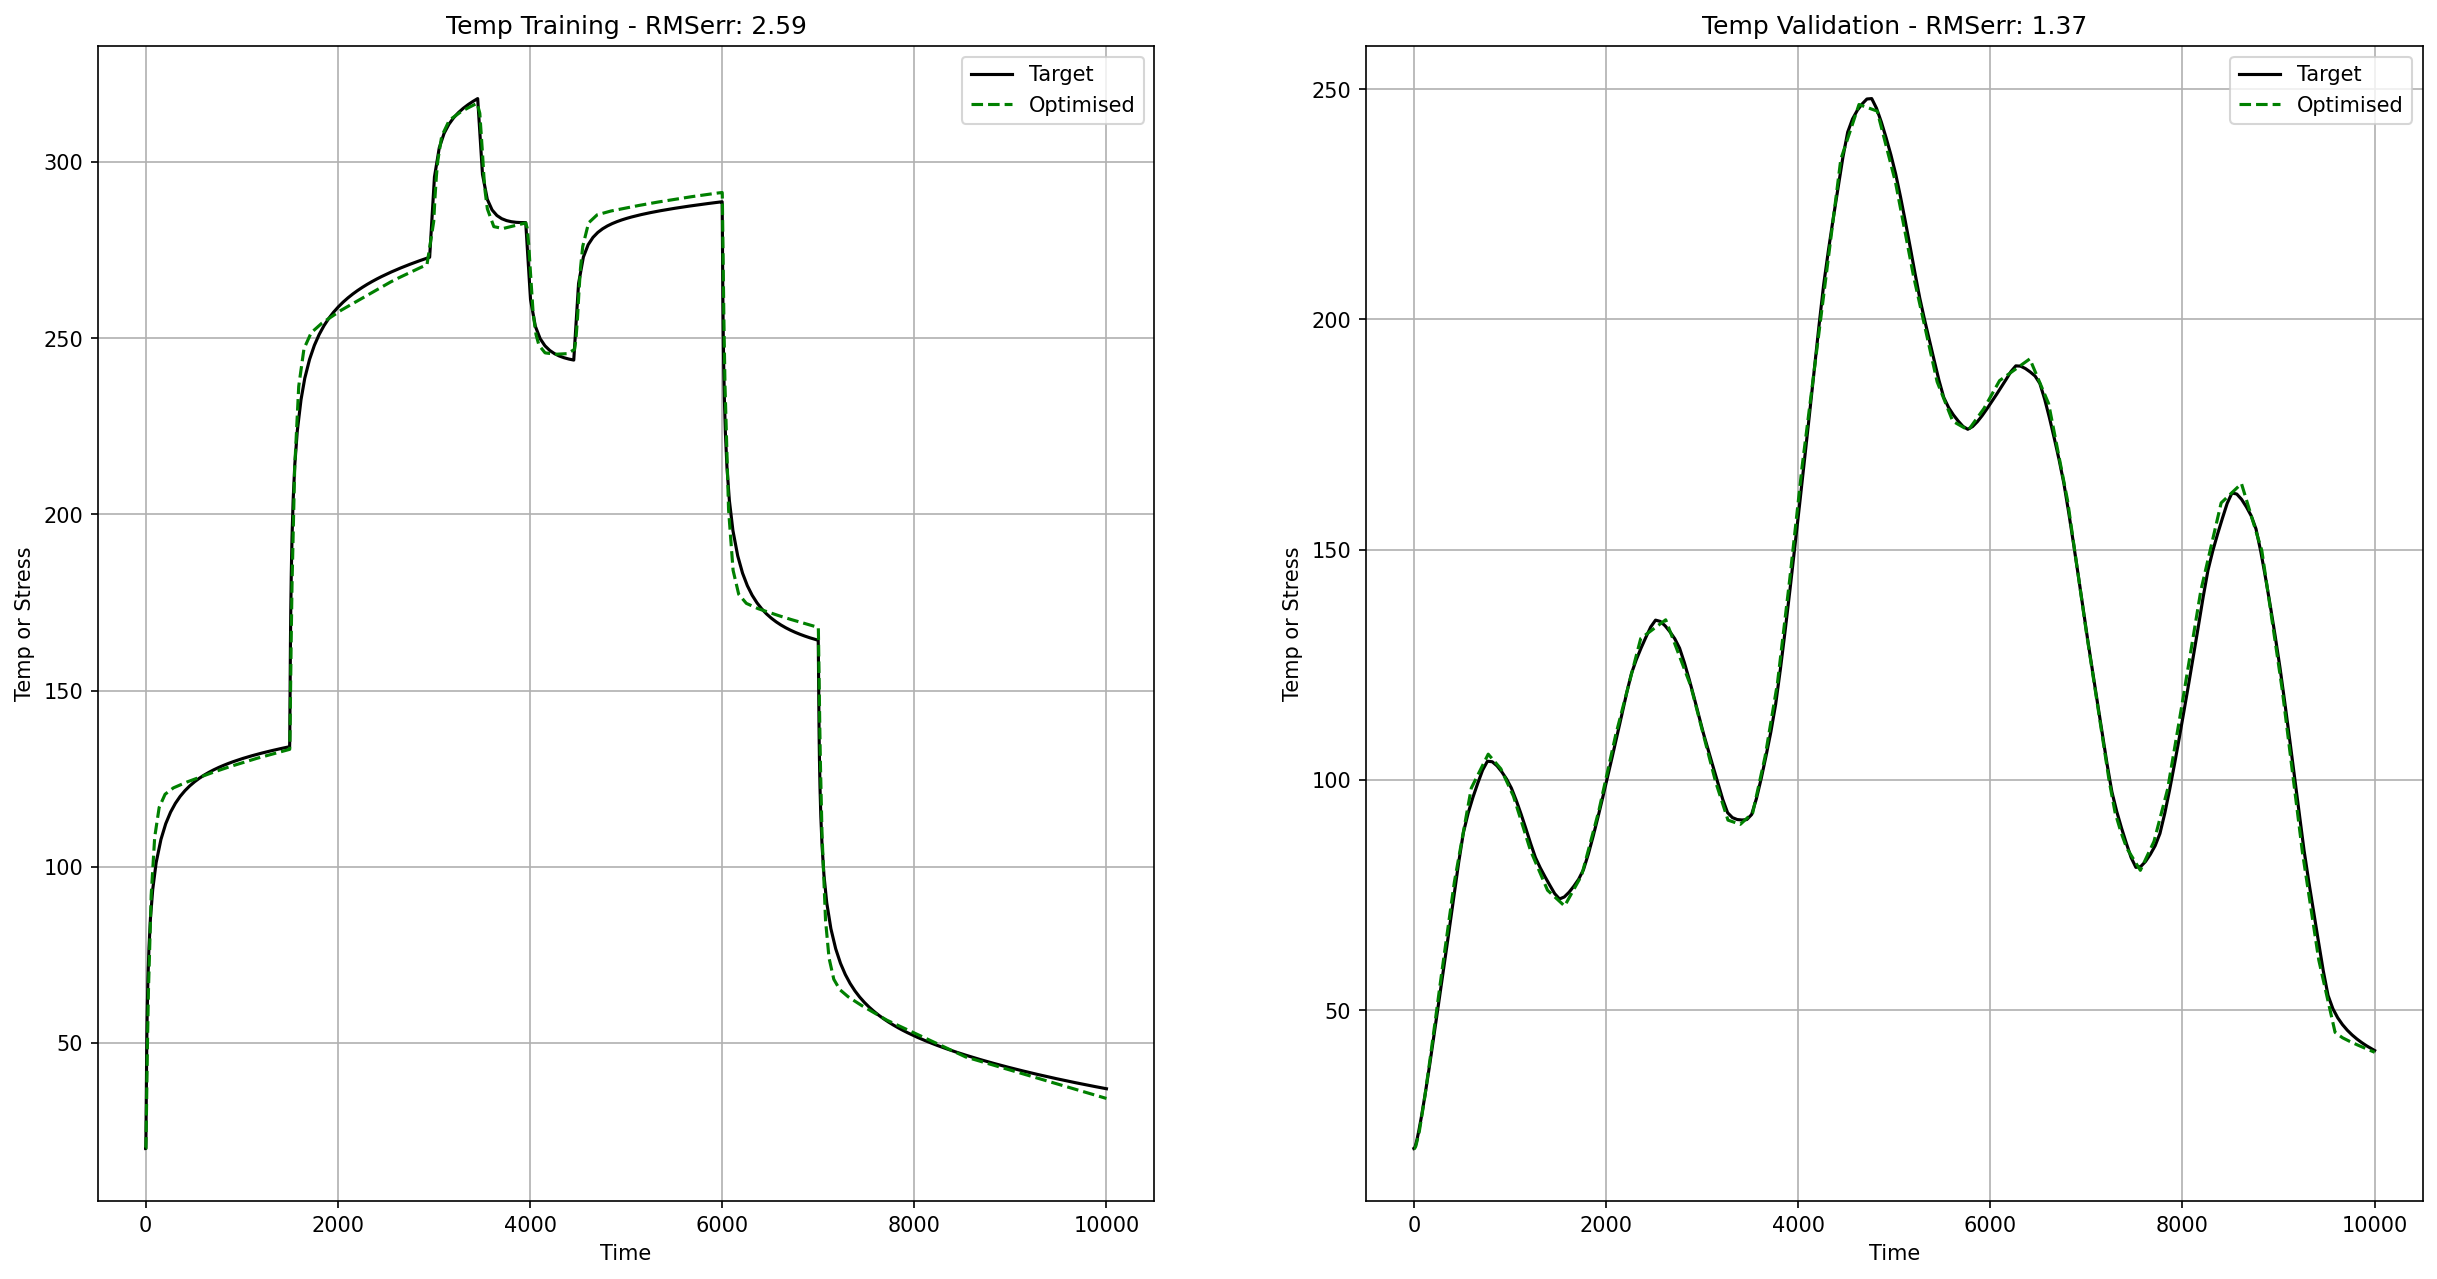

In [9]:
import matplotlib.pyplot as plt

output_name = "n28_Interface_Mid"

mOptArray = np.array([candidates[0], 1.0, candidates[1]])
kOptArray = np.array([candidates[2], candidates[3]])
hOptArray = np.array([candidates[4], candidates[5]])
cOptArray = np.array([0.0, 1.0, 0.0])


print(problem.rom.output_column)
print("--- mass ---")
print(mOptArray)
print("--- k ---")
print(kOptArray)
print("--- h ---")
print(hOptArray)
print("--- c ---")
print(cOptArray)

# # solve ODE and calculate error
model_parameters = {"m": mOptArray, "k": kOptArray, "h": hOptArray, "c": cOptArray}
optErrTraining, solOpt, optYTraining = problem.rom.ErrorCalculation(model_parameters)

# -----------------------------------------------------------------------------
# %%Check against validation case
# -------------------
# solve ODE and calculate error
optErrValidation, solOptVal, optYValidation = problem.rom.ErrorCalculation(
    model_parameters, validation_mode=True
)
# -----------------------------------------------------------------------------

# %% Plots
# -----------------------------------------------------------------------------
# fit results
plt.figure()
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10), fig.set_figwidth(20), fig.set_dpi(150)
axs[0].plot(
    problem.rom.target_data[0], problem.rom.target_data[1], "k-", label="Target"
)
axs[0].plot(solOpt.t, optYTraining, "g--", label="Optimised")
axs[0].set(xlabel="Time", ylabel="Temp or Stress")
axs[0].legend()
axs[0].grid()
axs[0].set_title(
    problem.rom.output_column + " Training - RMSerr: " + "{:.2f}".format(optErrTraining)
)
# Validation results
validationDataArray = (
    problem.rom.validation_data[["Time", problem.rom.output_column]]
    .to_numpy()
    .transpose()
)
axs[1].plot(validationDataArray[0], validationDataArray[1], "k-", label="Target")
axs[1].plot(solOptVal.t, optYValidation, "g--", label="Optimised")
axs[1].set(xlabel="Time", ylabel="Temp or Stress")
axs[1].legend()
axs[1].grid()
axs[1].set_title(
    problem.rom.output_column
    + " Validation - RMSerr: "
    + "{:.2f}".format(optErrValidation)
)

### Plot the Convergence to the minimum

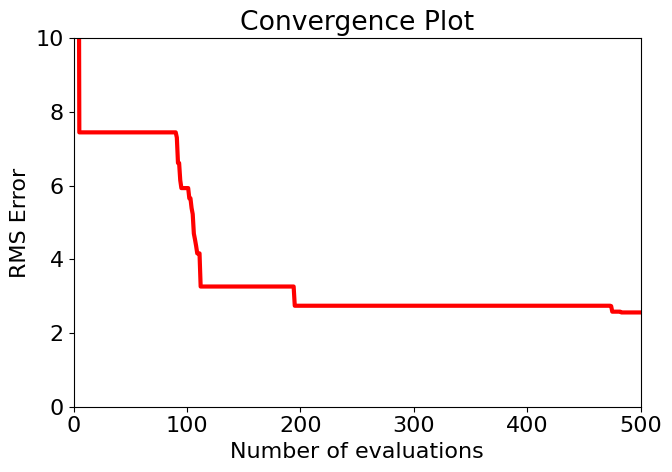

In [10]:
fx = solutions["f1"].values
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({"font.size": 16})
# plt.plot(fX, "b.", ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fx), "r", lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fx)])
plt.ylim([0, 10])
plt.xlabel("Number of evaluations")
plt.ylabel("RMS Error")
plt.title("Convergence Plot")

plt.tight_layout()
plt.show()